In [1]:
# Imports and data loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

/home/chhk/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
import sys
if sys.maxsize > 2**32:
    print('64-bit')
else:
    print('32-bit')

64-bit


In [3]:
first_150k = pd.read_csv('../input/wine-reviews/winemag-data_first150k.csv', index_col=0)
data_csv = pd.read_csv('../input/wine-reviews/winemag-data-130k-v2.csv', index_col=0)
data_json = pd.read_json('../input/wine-reviews/winemag-data-130k-v2.json')

data = data_csv
target_data = data['points']
feature_data = data.drop('points', axis=1)

## Read the manual
The 'manual' for this data comes in the form of text descriptions on the kaggle site about this data that I have copied and pasted into a txt file, then formatted. 

>Here is a CSV version of the data I scraped. This dataset has three new fields  
--Title (which you can parse the vintage from), Taster Name, and Taster Twitter Handle. This should also fix the duplicate entries problem in the first version of the dataset and add ~25k unique reviews to play with. 

So There are two copies of the dataset, one of which I can see is duplicated in .json form. 

> After watching Somm (a documentary on master sommeliers) I wondered how I could create a predictive model to identify wines through blind tasting like a master sommelier would. The first step in this journey was gathering some data to train a model. I plan to use deep learning to predict the wine variety using words in the description/review. The model still won't be able to taste the wine, but theoretically it could identify the wine based on a description that a sommelier could give. If anyone has any ideas on how to accomplish this, please post them!

So their purpose was similar to mine: pick good wines. 

>winemag-data-130k-v2.csv contains 10 columns and 130k rows of wine reviews.  
winemag-data_first150k.csv contains 10 columns and 150k rows of wine reviews.  
winemag-data-130k-v2.json contains 6919 nodes of wine reviews.

There are three files, one of which is the 'first', and the other two are 'v2', but in different file formats. 

>The data was scraped from WineEnthusiast during the week of June 15th, 2017. The code for the scraper can be found here if you have any more specific questions about data collection that I didn't address.  
**UPDATE 11/24/2017** After feedback from users of the dataset I scraped the reviews again on November 22nd, 2017. This time around I collected the title of each review, which you can parse the year out of, the tasters name, and the taster's Twitter handle. This should also fix the duplicate entry issue.

The data was acquired by web scraping, and then an updated version was scraped that removed some issues with the data. I guess that's what 'first' and 'v2' are referring to. 

>**Inspiration**  
I think that this dataset offers some great opportunities for sentiment analysis and other text related predictive models. My overall goal is to create a model that can identify the variety, winery, and location of a wine based on a description. If anyone has any ideas, breakthroughs, or other interesting insights/models please post them.

Yes. This is a worthy goal. 

>Numeric: unnamed, but functions as a count from 0 ID number  
**String: country**  
The country that the wine is from  
**String: description**  
A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.  
**String: designation**  
The vineyard within the winery where the grapes that made the wine are from  
**Numeric: points**  
The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)  
**Numeric: price**  
The cost for a bottle of the wine  
**String: province**  
The province or state that the wine is from  
**String: region_1**  
The wine growing area in a province or state (ie Napa)  
**String: region_2**  
Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank  
**String: taster_name**  
Name of the person who tasted and reviewed the wine  
**String: taster_twitter_handle**  
Twitter handle for the person who tasted and reviewed the wine  
**String: title**  
The title of the wine review, which often contains the vintage if you're interested in extracting that feature  
**String: variety**  
The type of grapes used to make the wine (ie Pinot Noir)  
**String: winery**  
The winery that made the wine  

Useful data types and descriptions for the 14 columns. One of them is just an ID column, which I'll incorporate into the dataframe as the index upon loading. The rest are useful looking things, including a freeform text description, name, point score, price, location data, reviewer data (who wrote the description and gave the point score), some text data indicating it's name and year the grapes were picked, the variety of grapes, and the winery that produced the wine. 

Most significantly, above all previous wine-related datasets, these features (besides points and reviewer) are things I can actually find out by reading the label in the shop. This is probably the most useful wine related dataset so far (it's also by far the largest). 

The text data is all freeform and needs to be processed to make it usable. Some needs simple encoding, others require further processing to be useful. 

## Basics
What does the data look like?  
How much of it is there?  
What type of data is it? 

In [4]:
first_150k.sample(5, random_state=4)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
31034,US,"The aromas seem a bit muddled, with notes of j...",Colter's Creek Estate,84,10.0,Idaho,Idaho,NaN,Riesling,Colter's Creek
58,US,Cabernet makes up just over half of this blend...,Final Final,90,30.0,Washington,Columbia Valley (WA),Columbia Valley,Cabernet Sauvignon-Syrah,Efeste
24657,Italy,"Le Macchiole's Bolgheri Rosso blend (Merlot, C...",NaN,90,30.0,Tuscany,Bolgheri,NaN,Red Blend,Le Macchiole
139801,Italy,"A special, gentle wine with caressing persiste...",NaN,92,60.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese,Fornacina
1820,US,Winemaker Nick Goldschmidt does wonders with t...,Lone Tree Vineyard,90,50.0,California,Alexander Valley,Sonoma,Cabernet Sauvignon,Forefathers


The first data collected has fewer columns, but is otherwise as described. Since I've already decided not to use the old data, and to work with the more recently collected data (that also has more features), I will not analyse this any further. 

In [5]:
data_csv.sample(5, random_state=4)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
105424,France,Steinbach is a village at the extreme southern...,Steinbach,90,35.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Joseph Cattin 2010 Steinbach Pinot Noir (Alsace),Pinot Noir,Joseph Cattin
30811,US,"Salted lemon rinds, ice-cold apple, fresh-sque...",Bien Nacido Vineyard Block II Mount Eden Clone,92,46.0,California,Santa Maria Valley,Central Coast,Matt Kettmann,@mattkettmann,Scar of the Sea 2013 Bien Nacido Vineyard Bloc...,Chardonnay,Scar of the Sea
86983,Italy,"Delicately scented, this offers subtle aromas ...",Occhi di Ciumi,89,20.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Al-Cantàra 2015 Occhi di Ciumi (Etna),White Blend,Al-Cantàra
109619,US,"As sweet as angel food cake, with sugary vanil...",NaN,82,14.0,California,Central Coast,Central Coast,NaN,NaN,Cupcake 2008 Chardonnay (Central Coast),Chardonnay,Cupcake
98442,France,"Very dense and firm, this has powerful tannins...",NaN,94,NaN,Bordeaux,Pessac-Léognan,NaN,Roger Voss,@vossroger,Château Smith Haut Lafitte 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Smith Haut Lafitte


The features all seem to be as described. Notably, the points are in integers and price is in decimals. Also, in this random sample of 5 rows I can already see seven data are missing. Much of the longer text data is inconsistent in structure, though all seem to have a year (vintage) which - if present in enough of them - could be useful for determining the age of the wine. Relevantly, the reviews were scraped on 22/02/2017. 

In [6]:
data_json.sample(5, random_state=4)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
105424,France,Steinbach is a village at the extreme southern...,Steinbach,90,35.0,Alsace,Alsace,None,Roger Voss,@vossroger,Joseph Cattin 2010 Steinbach Pinot Noir (Alsace),Pinot Noir,Joseph Cattin
30811,US,"Salted lemon rinds, ice-cold apple, fresh-sque...",Bien Nacido Vineyard Block II Mount Eden Clone,92,46.0,California,Santa Maria Valley,Central Coast,Matt Kettmann,@mattkettmann,Scar of the Sea 2013 Bien Nacido Vineyard Bloc...,Chardonnay,Scar of the Sea
86983,Italy,"Delicately scented, this offers subtle aromas ...",Occhi di Ciumi,89,20.0,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Al-Cantàra 2015 Occhi di Ciumi (Etna),White Blend,Al-Cantàra
109619,US,"As sweet as angel food cake, with sugary vanil...",None,82,14.0,California,Central Coast,Central Coast,None,None,Cupcake 2008 Chardonnay (Central Coast),Chardonnay,Cupcake
98442,France,"Very dense and firm, this has powerful tannins...",None,94,NaN,Bordeaux,Pessac-Léognan,None,Roger Voss,@vossroger,Château Smith Haut Lafitte 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Smith Haut Lafitte


Immediately, this data looks the same as `data_csv`, except that 'NaN' is replaced by 'None' in the cases of missing data. 

In [7]:
data_json.equals(data_csv)

True

They are exactly the same, and the 'NaN'-'None' difference is a formatting difference between csv and json data. I can safely disregard `data_json`. This leaves a single data file, in CSV format, left to continue with. 

In [8]:
data_csv.shape

(129971, 13)

With 13 features and 129,971 samples, there are 1,689,623 pices of data. 
- **country**: String. Nominal categorical. 
- **description**: String. Freeform text. 
- **designation**: String. Freeform text. 
- **points**: Numeric. Integer ratio. 
- **price**: Numeric. Continuous ratio. 
- **province**: String. Nominal categorical. 
- **region_1**: String. Nominal categorical. 
- **region_2**: String. Nominal categorical. 
- **taster_name**: String. Nominal categorical. 
- **taster_twitter_handle**: String. Nominal categorical. 
- **title**: String. Freeform text. Contains an integer interval datum that could be parsed. 
- **variety**: String. Nominal categorical. 
- **winery**: String. Nominal categorical. 

## Target variable
Datatype?  
Descriptive statistics?  
Unbalanced? Does it need weighting?  
Is it linearly separable?  
What sorts of models can predict this?  

The target variable is `points`. It's data type is integer ratio. 

In [9]:
# Descriptive statistics
target_data.describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

There is no missing data in the target variable. There are also no scores below 80, which on a 0-100 score system would be farcical - I imagine the dataset was gathered explicitly excluding wines with point scores below that threshold? 

Having just read the code that scraped the website, I've found that it was hardcoded to scrape all the pages of reviews that were there at the time. I then went to the website itself; [ https://www.winemag.com/?s=&drink_type=wine&page=1&sort_by=rating&sort_dir=asc ], and discoverd that of 249,314 reiviews, only two were below 80. One is 22 points, and the other is 44 and marked as a duplicate. 

As I read further, I found this explanation of their ratings (table headers and formatting added by me): 

>| Score range | Quality | Description |
>|---|---|---|
>| 98–100 | Classic | The pinnacle of quality. |
>| 94–97 | Superb | A great achievement. |
>| 90–93 | Excellent | Highly recommended. |
>| 87–89 | Very Good | Often good value; well recommended. |
>| 83–86 | Good | Suitable for everyday consumption; often good value. |
>| 80–82 | Acceptable | Can be employed in casual, less-critical circumstances. |
>
>Products deemed Unacceptable (receiving a rating below 80 points) are not reviewed.

Which explains this completely. I don't know why the two sub-80 reviews aren't in this dataset, but they're clearly anomalies and I will discount them. 

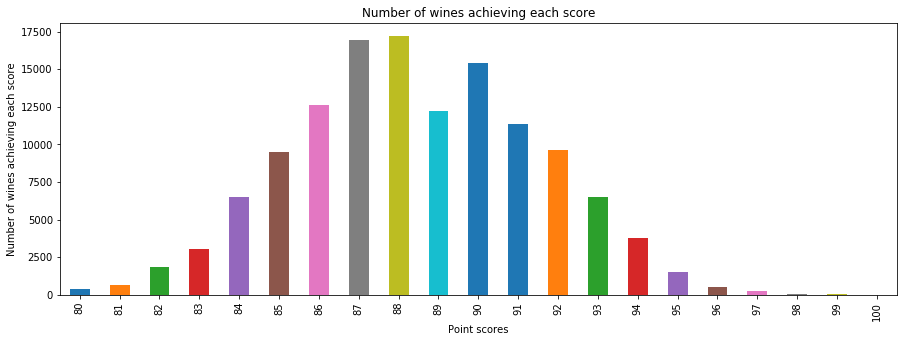

In [10]:
ax_1 = target_data.value_counts().sort_index().plot.bar(title='Number of wines achieving each score', figsize=(15,5));

ax_1.set_xlabel('Point scores');
ax_1.set_ylabel('Number of wines achieving each score');

In [11]:
stats_describe_target = stats.describe(target_data)
print('Target data skewness: {}'.format(stats_describe_target.skewness))
print('Target data kurtosis: {}'.format(stats_describe_target.kurtosis))

Target data skewness: 0.04592022248056047
Target data kurtosis: -0.29599796801102096


These skewness and kurtosis scores make sense, and the distribution of the target variable does look rather like a normal distribution, give or take. 

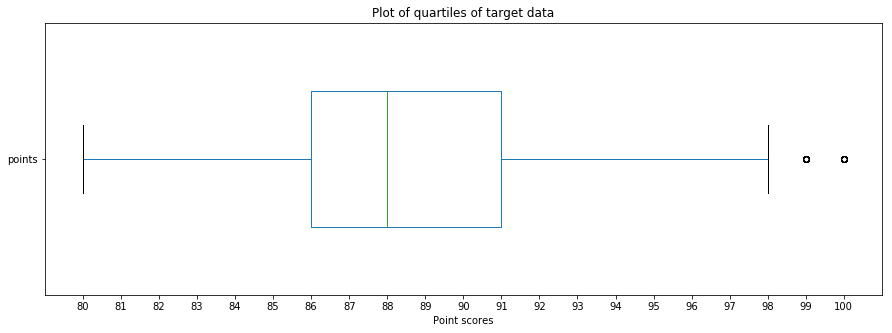

In [12]:
ax_2 = target_data.plot.box(title='Plot of quartiles of target data', figsize=(15,5), vert=False, widths=0.5)

ax_2.set_xticks(target_data.value_counts().sort_index().index);
ax_2.set_xlabel('Point scores');

This boxplot shows that despite the distribution being fairly normal, it does have outliers - fortunately it doesn't look like there are too many. Since they're everything above 98, I'll check how many there are: 

In [13]:
target_data[target_data>98].size

52

Apparently there are 52 suspected outliers in this dataset, which out of 129,971, isn't many. Unless there's a specific reason to remove them, I'll leave them in, and consider any further engineering of them when I have more context, if necessary. 

Seeing as how this data is integer ratio data, it is evidently linearly separable. I will consider using regression models to make predictive models for this. 

## Feature data
### Numeric
Independent or dependent?  
What are the descriptive statistics of the data?  
Is it sparse or dense?  
How much of it is missing?  

Some of the features are independent of each other, in so far as anything in the physical universe is independent of anything else, though several are not. taster_name and taster_twitter_handle, which seem to share some similarity, for obvious reasons. It is likely that one of these will be dropped before the analysis, because it's duplicate information. 

In [14]:
feature_data.describe()

,price
count,120975.000000
mean,35.363389
std,41.022218
min,4.000000
25%,17.000000
50%,25.000000
75%,42.000000
max,3300.000000


Since price is the only numerical feature variable, `pd.describe()` has limited use.  
That said, looking at this shows some interesting things: the standard deviation is larger than the mean for a continuous ratio variable, and three percentiles, as well as the standard deviation and the mean, are all two orders of magnitude smaller than the max value. I'd like to see what a boxplot labels as suspected outliers: 

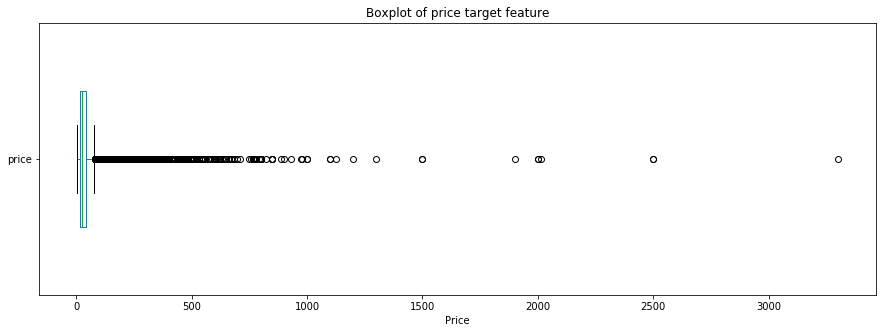

In [15]:
ax_3 = feature_data.price.plot.box(x='price', figsize=(15,5), vert=False, widths=0.5, title='Boxplot of price target feature');

ax_3.set_xlabel('Price');

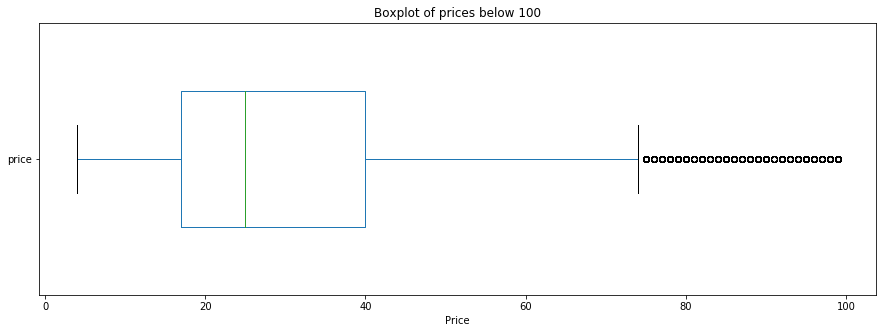

In [16]:
ax_4 = feature_data[feature_data.price<100].price.plot.box(x='price', figsize=(15,5), vert=False, widths=0.5, title='Boxplot of prices below 100');

ax_4.set_xlabel('Price');

That's a huge part of the range that's outlier territory, from 72 to 3000+. 

In [17]:
feature_data[feature_data.price>=72].shape

(9284, 12)

9284/129971=0.07, which make 7% of the price feature outliers. That's a large amount. 

Now that I've had a cursory look at the only numeric feature variable available, I'll take a wider look at the rest of the feature variables. 

In [18]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 12 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), object(11)
memory usage: 12.9+ MB


Of the features; 
- country
- description
- province
- title
- variety
- winery 

appear to be mostly non-null data, whereas; 
- designation
- price
- region_1
- taster_name

have what could be a usable amount of data present, but;
- designation
- region_2
- taster_twitter_handle

have more than 30,000 missing data points, and that's a lot of data to have to delete or usefully interpolate. 

On the upside, as it stands this isn't a sparse dataset. On the downside, as it stands most (10 out of 11) of the features require transformation of some form or another beyond straightforward standardisation. 

Given that some exclusionary choices might have to be made, it would be helpful to know about the variety of different values for the (straightforwardly, at least) categorical features. 

In [19]:
categorical_features = 'country', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'variety', 'winery'
raw_cat_features = feature_data.loc[:, categorical_features]
raw_cat_features.T.apply(lambda x: x.nunique(), axis=1).sort_index()

country                     43
province                   425
region_1                  1229
region_2                    17
taster_name                 19
taster_twitter_handle       15
variety                    707
winery                   16757
dtype: int64

Putting that next to some other numbers that describe how much of it is there: 

|Feature|Non-null|Null|Percentage null|Count of unique values|
|---|---|---|---|---|
|country|129,908|63|0.05%|43|
|province|129,908|63|0.05%|425|
|region_1|108,724|21,247|16.35%|1229|
|region_2|50,511|79,460|61.14%|17|
|taster_name|103,727|26,244|20.19%|19|
|taster_twitter_handle|98,758|31,213|24.02%|15|
|variety|129,970|1|0.00%|707|
|winery|129,971|0|0.00%|16757|

'Common wisdom' suggests that features with more than somewhere in the range of 25-30% missing data should be discarded, and those with less should be considered for imputation or setting nulls to zero. In this case that would include region_2 and no others by default, though given how much is missing from taster_twitter_handle and how much of a duplicate it is of taster_name, I would consider removing it as well. 

In [20]:
df_non_null = raw_cat_features.dropna(subset=categorical_features, axis='index', how='any')
print('Number of rows with no null values: {}'.format(df_non_null.shape[0]))

Number of rows with no null values: 32413


Removing ~100,000 rows (75%) from the dataset is too much. If I only consider the more populous columns, however: 

In [21]:
df_non_null_subset = raw_cat_features.dropna(subset=['country', 'province', 'region_1', 'taster_name', 'variety', 'winery'], axis='index', how='any')
print('Number of rows left with no null values after dropping region_2 and taster_twitter_handle: {}'.format(df_non_null_subset.shape[0]))

Number of rows left with no null values after dropping region_2 and taster_twitter_handle: 82847


Removing 47,124 rows (36%) of the rows is less extreme, but I'd still rather not throw away a third of the data. Imputation it is. 

A relevant and meaningful question to consider before/along side this sort of decision is how to represent the data that I'm considering imputing? Most of it's text, which means categorical, and it's representation affects both the outcome of an analysis and how it is imputed - are countries represented as a single feature and each country is a different integer? How does this implicitly ordered definition interact with model learning? Should they be represented with a new feature for each country, and that is defined by a 0/1? Will imputations try to make wines have more than one country? Will it add so many new features as to cast the curse of dimensionality? 

Another relevant question to ask, is what happens if I just remove the features with the missing data? Will I really miss out on all tha tmuch if I drop 'region_2' and 'taster_twitter_handle'? Perhaps I will not. 

What I will do is take a quicker and easier approach, and if that doesn't get me what I want, then I'll revisit it.  
For now though, I'll carry on with exploring the features. 

### Graphical

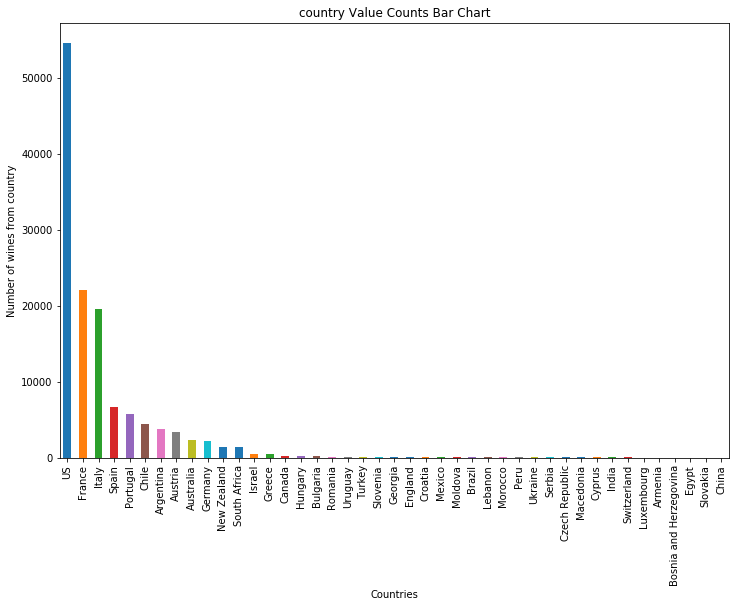

In [22]:
ax_5 = feature_data.country.value_counts().plot.bar(title='country Value Counts Bar Chart', figsize=(12,8));

ax_5.set_xlabel('Countries');
ax_5.set_ylabel('Number of wines from country');

In [23]:
feature_data.country.value_counts().tail(10)

Macedonia                 12
Cyprus                    11
India                      9
Switzerland                7
Luxembourg                 6
Armenia                    2
Bosnia and Herzegovina     2
Egypt                      1
Slovakia                   1
China                      1
Name: country, dtype: int64

The US has a huge lead over the others in the number of wines, and this could dilue the usefulness of it as a predictor. Also, the last three countries have only one wine, which makes them not only hugely biased as predictor values, but also useless for testing - if they're trained on, they aren't in the test set, and if they're in the test set, they can't be trained on. 

In [24]:
feature_data.province.value_counts()

California                   36247
Washington                    8639
Bordeaux                      5941
Tuscany                       5897
Oregon                        5373
Burgundy                      3980
Northern Spain                3851
Piedmont                      3729
Mendoza Province              3264
Veneto                        2716
New York                      2688
Alsace                        2440
Northeastern Italy            2138
Loire Valley                  1856
Sicily & Sardinia             1797
Champagne                     1613
Southwest France              1503
Southern Italy                1349
South Australia               1349
Provence                      1346
Douro                         1281
Central Italy                 1233
Catalonia                     1164
Rhône Valley                  1081
Beaujolais                    1044
Mosel                         1039
Alentejano                     937
Colchagua Valley               830
Marlborough         

Well, obviously that can't be converted into 425 binary features. Also obvious: if California were listed as it's own country, it would be the largest wine producing country in the world. It produces more wine than any other actual country, and more than the rest of the USA put together. 

There are 54 provinces with only one wine, and 200 with less than or equal to ten wines. This will introduce the problem of imbalanced representation - a province with only one example will obviously introduce bias around that instance of that feature, and a province with 36,247 examples (~28% of the entire dataset) will both be heavily over represented, and possibly useless - unless all wines from California are somehow uniformally better or worse because of being from California, then it'll be useless because of it's commonness. If it does carry meaning, it may be because it _isn't_ another province, or because of how it can interact with other variables - which is only going to show up in more complex models. 

In [25]:
province_value_counts = feature_data.province.value_counts().value_counts().sort_index()

In [26]:
print('Number of provinces with that number of wines, where the value is the number of wines and the index is the number of provinces with that number of wines grown there.\n')
print('Number of different values: {}'.format(len(province_value_counts)))
print('\nHead: \n{}'.format(province_value_counts.head(10)))
print('\nTail: \n{}'.format(province_value_counts.tail(10)))

Number of provinces with that number of wines, where the value is the number of wines and the index is the number of provinces with that number of wines grown there.

Number of different values: 143

Head: 
1     54
2     36
3     35
4     17
5     15
6     11
7     10
8      9
9      9
10     4
Name: province, dtype: int64

Tail: 
2716     1
3264     1
3729     1
3851     1
3980     1
5373     1
5897     1
5941     1
8639     1
36247    1
Name: province, dtype: int64


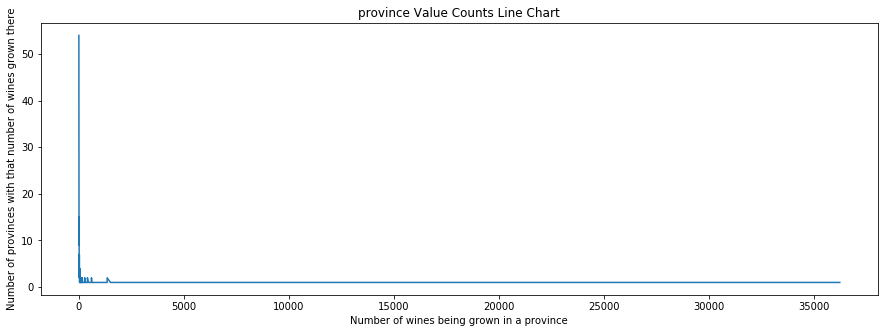

In [27]:
ax_6 = province_value_counts.plot.line(title='province Value Counts Line Chart', figsize=(15,5));

ax_6.set_xlabel('Number of wines being grown in a province');
ax_6.set_ylabel('Number of provinces with that number of wines grown there');

Clearly, most provinces listed in this dataset only have one corresponding wine. Given the nature of the dataset as one which consists only of good wines collated from around the world that is run from the USA, it is unsurprising that there would be more North American wines, and it also makes sense that since California is much larger than Ticino, it would make more wines that were good. However, the incredible imbalance towards american wines isn't something to blindly ignore. 

For the purposes of this project though, I only care about being able to identify decent wine in a shop based on features I can actually determine from the bottle with little effort (i.e. reading the label). So what if I end up drinking more Californian wine than Swiss wine? The objective has nothing to do with that. 

In [28]:
region_1_value_counts = feature_data.region_1.value_counts()

In [29]:
region_1_value_counts

Napa Valley                    4480
Columbia Valley (WA)           4124
Russian River Valley           3091
California                     2629
Paso Robles                    2350
Willamette Valley              2301
Mendoza                        2301
Alsace                         2163
Champagne                      1613
Barolo                         1599
Finger Lakes                   1565
Sonoma Coast                   1474
Brunello di Montalcino         1470
Rioja                          1469
Sonoma County                  1246
Toscana                        1197
Walla Walla Valley (WA)        1066
Chianti Classico               1062
Santa Barbara County           1000
Carneros                        999
Yakima Valley                   997
Sta. Rita Hills                 975
Dry Creek Valley                939
Sicilia                         925
Côtes de Provence               859
Santa Ynez Valley               812
Santa Lucia Highlands           806
Lodi                        

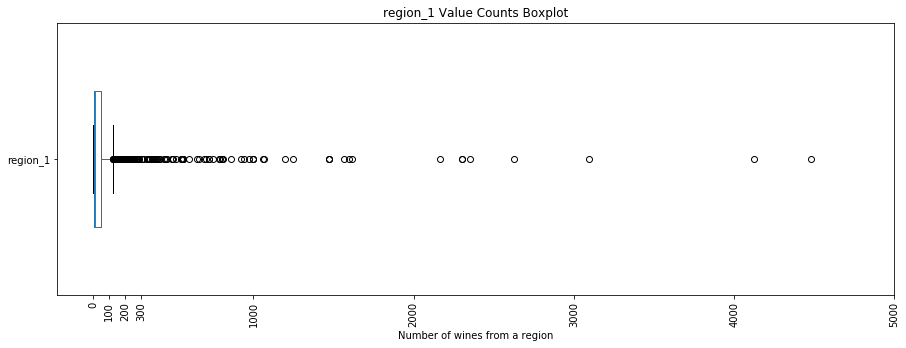

In [30]:
ax_7 = region_1_value_counts.plot.box(title='region_1 Value Counts Boxplot', figsize=(15,5), vert=False, widths=0.5)

ax_7.set_xticks([0, 100, 200, 300, 1000, 2000, 3000, 4000, 5000]);
ax_7.set_xticklabels([0, 100, 200, 300, 1000, 2000, 3000, 4000, 5000], rotation=90);
ax_7.set_xlabel('Number of wines from a region');

This shows that the same imbalance that was present in province is present in region_1. I think it will continue to be present in most if not all of the geospatial features of this dataset. 

This boxplot is covered in outliers, and playing around with the graph's widths parameter I found that they start around 125. Running with that for now, I'll find out how much of this feature is made up of outliers. 

In [31]:
less_than_125 = len(region_1_value_counts[region_1_value_counts<=125])
greater_than_125 = len(region_1_value_counts[region_1_value_counts>125])
total_region_1_value_counts = len(region_1_value_counts)

print('region_1 value counts <= 125: {}, {}%.'.format(less_than_125, '{:.2f}'.format((less_than_125/total_region_1_value_counts)*100)))
print('region_1 value counts >  125: {}, {}%.'.format(greater_than_125, '{:.2f}'.format((greater_than_125/total_region_1_value_counts)*100)))

region_1 value counts <= 125: 1059, 86.17%.
region_1 value counts >  125: 170, 13.83%.


So, ~14% of unique region_1 values are outliers, which isn't the end of the world. Just to get another view on this, I'll display it in terms of area under a line. 

Now I want to see how steep the curve is on a graph showing how many regions have each number of wines is. 

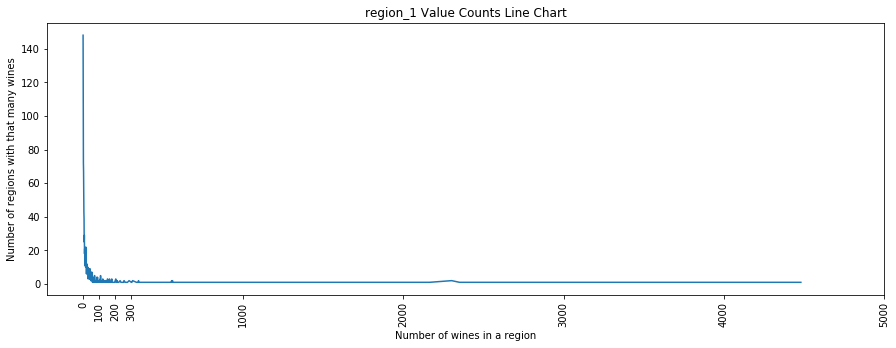

In [32]:
ax_8 = region_1_value_counts.value_counts().sort_index().plot.line(title='region_1 Value Counts Line Chart', figsize=(15,5))

ax_8.set_xticks([0, 100, 200, 300, 1000, 2000, 3000, 4000, 5000]);
ax_8.set_xticklabels([0, 100, 200, 300, 1000, 2000, 3000, 4000, 5000], rotation=90);
ax_8.set_xlabel('Number of wines in a region');
ax_8.set_ylabel('Number of regions with that many wines');

That's a very steep curve, and some extreme right skew. Given that this is a categorical variable, there isn't a lot I can do directly (like standardisation of numerical features). I can't find any reason to discard this feature. 

In [33]:
region_2_value_counts = feature_data.region_2.value_counts()

In [34]:
region_2_value_counts

Central Coast        11065
Sonoma                9028
Columbia Valley       8103
Napa                  6814
Willamette Valley     3423
California Other      2663
Finger Lakes          1777
Sierra Foothills      1462
Napa-Sonoma           1169
Central Valley        1062
Southern Oregon        917
Oregon Other           727
Long Island            680
North Coast            584
Washington Other       534
South Coast            272
New York Other         231
Name: region_2, dtype: int64

That is a _lot_ less variation. It also looks like just a lot less in general, which makes sense because ~61% of it's missing. That, combined with already having a location related feature that is has far fewer missing data and is more specific, immediately inclines me to discard this feature altogether. First, though, I should at least take a look. 

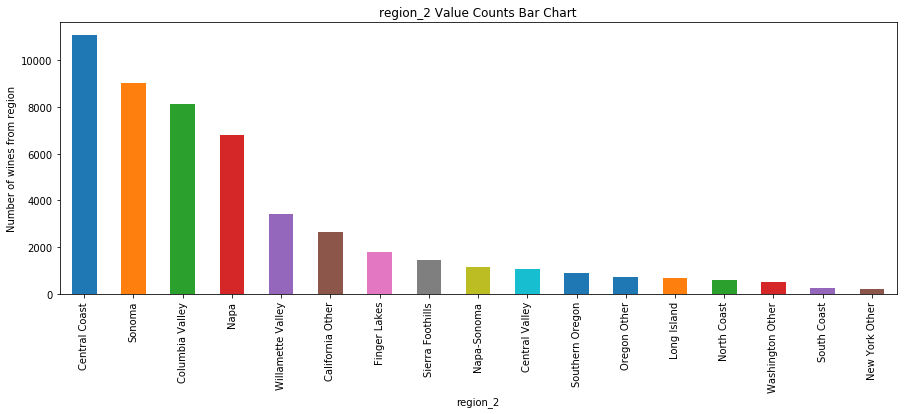

In [35]:
ax_9 = region_2_value_counts.plot.bar(title='region_2 Value Counts Bar Chart', figsize=(15,5));

ax_9.set_xlabel('region_2');
ax_9.set_ylabel('Number of wines from region');

It has just occured to me to check the number of unique combinations of region_1 and region_2 (where region_2 is not null) is equal to the number of unique region_1 samples (where region_2 is not null). 

In [36]:
non_null_region_2_feature_data = feature_data.dropna(subset=['region_2'], axis='index', how='any')
region_1_unique_where_region_2_non_null = non_null_region_2_feature_data.groupby(['region_1']).size().reset_index().rename(columns={0:'count'})
region_1_and_2_unique_where_region_2_non_null = non_null_region_2_feature_data.groupby(['region_1', 'region_2']).size().reset_index().rename(columns={0:'count'})
print(region_1_unique_where_region_2_non_null.shape)
print(region_1_and_2_unique_where_region_2_non_null.shape)

(202, 2)
(203, 3)


Two things that have just come to my attention; 
1. Those are different numbers, and I'll find out why next. 
2. region_2 has value anyway, and it's null instances can just be set as 0 to make it easier for the algorithm to ignore it when it's missing. 

In [37]:
# I'm leaving this in because I used it, but I'm commenting it out because it's a huge and otherwise useless printout. 
# unique_regions = pd.DataFrame([region_1_unique_where_region_2_non_null.region_1, region_1_and_2_unique_where_region_2_non_null.region_1])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(unique_regions)

# Napa-Sonoma
region_1_and_2_unique_where_region_2_non_null[region_1_and_2_unique_where_region_2_non_null.region_1=='Napa-Sonoma']

,region_1,region_2,count
102,Napa-Sonoma,Napa-Sonoma,18
103,Napa-Sonoma,North Coast,1


Given that both 'Napa-Sonoma' and 'North Coast' are both used as values for region_2 by many other data samples, I'll leave this as is and retain the information. 

In [38]:
taster_name_value_counts = feature_data.taster_name.value_counts()

In [39]:
taster_name_value_counts

Roger Voss            25514
Michael Schachner     15134
Kerin O’Keefe         10776
Virginie Boone         9537
Paul Gregutt           9532
Matt Kettmann          6332
Joe Czerwinski         5147
Sean P. Sullivan       4966
Anna Lee C. Iijima     4415
Jim Gordon             4177
Anne Krebiehl MW       3685
Lauren Buzzeo          1835
Susan Kostrzewa        1085
Mike DeSimone           514
Jeff Jenssen            491
Alexander Peartree      415
Carrie Dykes            139
Fiona Adams              27
Christina Pickard         6
Name: taster_name, dtype: int64

In [40]:
taster_name_value_counts.sum()

103727

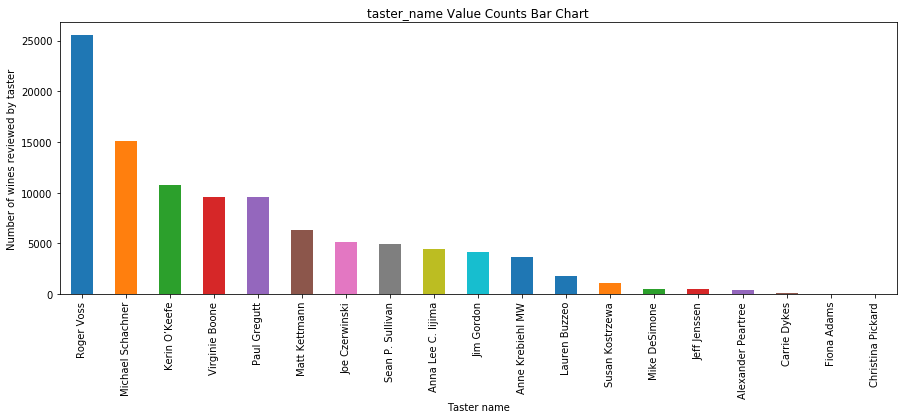

In [41]:
ax_10 = taster_name_value_counts.plot.bar(title='taster_name Value Counts Bar Chart', figsize=(15,5));

ax_10.set_xlabel('Taster name');
ax_10.set_ylabel('Number of wines reviewed by taster');

The same general shape as region_1 and region_2, and not so awful. Roger Voss is responsible for approximately a quarter of all reviews with a named reviewer, and approxoimatly 20% of all reviews. 

In [42]:
taster_twitter_handle_value_counts = feature_data.taster_twitter_handle.value_counts()

In [43]:
taster_twitter_handle_value_counts

@vossroger          25514
@wineschach         15134
@kerinokeefe        10776
@vboone              9537
@paulgwine           9532
@mattkettmann        6332
@JoeCz               5147
@wawinereport        4966
@gordone_cellars     4177
@AnneInVino          3685
@laurbuzz            1835
@suskostrzewa        1085
@worldwineguys       1005
@bkfiona               27
@winewchristina         6
Name: taster_twitter_handle, dtype: int64

In [44]:
taster_twitter_handle_value_counts.sum()

98758

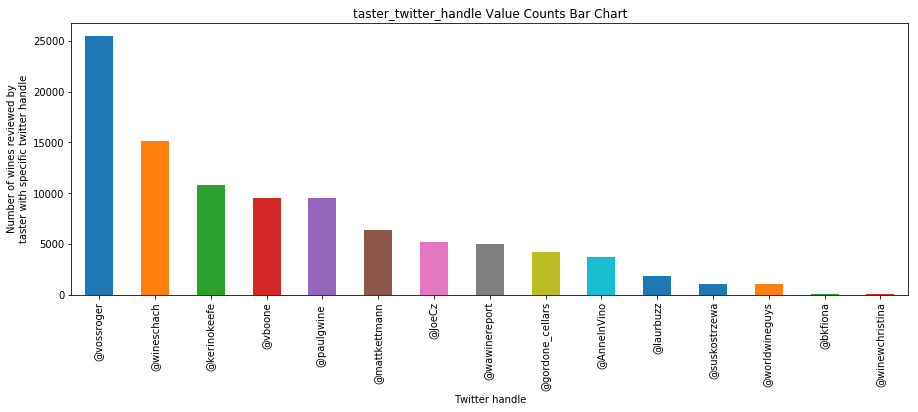

In [45]:
ax_11 = taster_twitter_handle_value_counts.plot.bar(title='taster_twitter_handle Value Counts Bar Chart', figsize=(15,5));

ax_11.set_xlabel('Twitter handle');
ax_11.set_ylabel('Number of wines reviewed by\ntaster with specific twitter handle');

Unsurprisingly similar to the taster_name feature, but the real question is how information do we get for the price of another dimension? 

In [46]:
non_null_name_data = feature_data.dropna(subset=['taster_name', 'taster_twitter_handle'], axis='index', how='any')
name_unique_where_twitter_not_null = non_null_name_data.groupby(['taster_name']).size().reset_index().rename(columns={0:'count'})
name_and_twitter_unique_where_twitter_not_null = non_null_name_data.groupby(['taster_name', 'taster_twitter_handle']).size().reset_index().rename(columns={0:'count'})
print(name_unique_where_twitter_not_null.shape)
print(name_and_twitter_unique_where_twitter_not_null.shape)

(16, 2)
(16, 3)


In [47]:
non_null_taster_data = feature_data.dropna(subset=['taster_name', 'taster_twitter_handle'], axis='index', how='any')
twitter_unique_where_name_not_null = non_null_name_data.groupby(['taster_twitter_handle']).size().reset_index().rename(columns={0:'count'})
twitter_and_name_unique_where_name_not_null = non_null_name_data.groupby(['taster_twitter_handle', 'taster_name']).size().reset_index().rename(columns={0:'count'})
print(name_and_twitter_unique_where_twitter_not_null.shape)
print(name_unique_where_twitter_not_null.shape)

(16, 3)
(16, 2)


In [48]:
taster_designations = feature_data[['taster_name', 'taster_twitter_handle']]

print('Taster names: ')
for name in taster_name_value_counts.index:
    print((taster_designations[taster_designations.taster_name==name].sample(1).iloc[0,0] + ", ").ljust(20) + (str(taster_designations[taster_designations.taster_name==name].sample(1).iloc[0,1]) + ": ").ljust(18) + str(taster_designations[taster_designations.taster_name==name].shape))

print('\nTaster twitters: ')
for twitter in taster_twitter_handle_value_counts.index:
    print((taster_designations[taster_designations.taster_twitter_handle==twitter].sample(1).iloc[0,0] + ", ").ljust(20) + (str(taster_designations[taster_designations.taster_twitter_handle==twitter].sample(1).iloc[0,1]) + ": ").ljust(18) + str(taster_designations[taster_designations.taster_twitter_handle==twitter].shape))

Taster names: 
Roger Voss,         @vossroger:       (25514, 2)
Michael Schachner,  @wineschach:      (15134, 2)
Kerin O’Keefe,      @kerinokeefe:     (10776, 2)
Virginie Boone,     @vboone:          (9537, 2)
Paul Gregutt,       @paulgwine :      (9532, 2)
Matt Kettmann,      @mattkettmann:    (6332, 2)
Joe Czerwinski,     @JoeCz:           (5147, 2)
Sean P. Sullivan,   @wawinereport:    (4966, 2)
Anna Lee C. Iijima, nan:              (4415, 2)
Jim Gordon,         @gordone_cellars: (4177, 2)
Anne Krebiehl MW,   @AnneInVino:      (3685, 2)
Lauren Buzzeo,      @laurbuzz:        (1835, 2)
Susan Kostrzewa,    @suskostrzewa:    (1085, 2)
Mike DeSimone,      @worldwineguys:   (514, 2)
Jeff Jenssen,       @worldwineguys:   (491, 2)
Alexander Peartree, nan:              (415, 2)
Carrie Dykes,       nan:              (139, 2)
Fiona Adams,        @bkfiona:         (27, 2)
Christina Pickard,  @winewchristina:  (6, 2)

Taster twitters: 
Roger Voss,         @vossroger:       (25514, 2)
Michael Sch

I've discovered something interesting: while there are more names than twitter handles, and there are no twitter handles without names, there are some twitter handles with _multiple_ names - look at the two lists above and check out @worldwineguys. They've got two reviewers, and that means that for the purposes of this dataset, twitter handles aren't unique reviewer names - they're organisational names and that's extra information, which means they stay. 

In [49]:
variety_value_counts = feature_data.variety.value_counts()

In [50]:
variety_value_counts

Pinot Noir                        13272
Chardonnay                        11753
Cabernet Sauvignon                 9472
Red Blend                          8946
Bordeaux-style Red Blend           6915
Riesling                           5189
Sauvignon Blanc                    4967
Syrah                              4142
Rosé                               3564
Merlot                             3102
Nebbiolo                           2804
Zinfandel                          2714
Sangiovese                         2707
Malbec                             2652
Portuguese Red                     2466
White Blend                        2360
Sparkling Blend                    2153
Tempranillo                        1810
Rhône-style Red Blend              1471
Pinot Gris                         1455
Champagne Blend                    1396
Cabernet Franc                     1353
Grüner Veltliner                   1345
Portuguese White                   1159
Bordeaux-style White Blend         1066


In [51]:
print('There are {} different numbers of varieties.'.format(len(variety_value_counts.value_counts().sort_index())))

There are 154 different numbers of varieties.


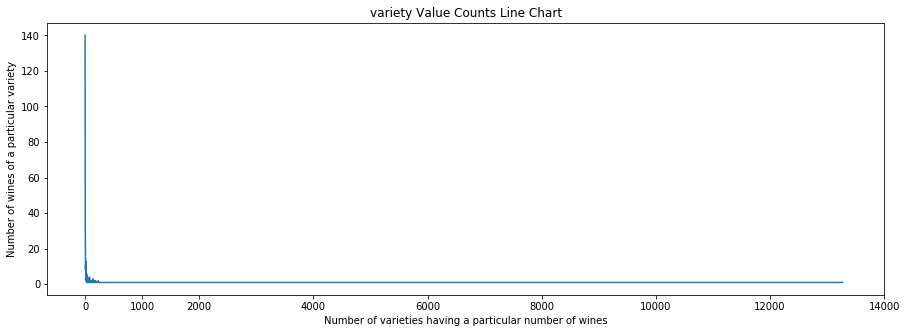

In [52]:
ax_12 = variety_value_counts.value_counts().sort_index().plot.line(title='variety Value Counts Line Chart', figsize=(15,5))

ax_12.set_xticks([0, 1000, 2000, 4000, 6000, 8000, 10000, 12000, 14000]);
ax_12.set_xticklabels([0, 1000, 2000, 4000, 6000, 8000, 10000, 12000, 14000]);
ax_12.set_xlabel('Number of varieties having a particular number of wines');
ax_12.set_ylabel('Number of wines of a particular variety');

Similar to region_1, with the same conclusion. A lot of right skew, still a relevant feature, not much engineering to be done. 

In [53]:
winery_value_counts = feature_data.winery.value_counts()

In [54]:
winery_value_counts

Wines & Winemakers                         222
Testarossa                                 218
DFJ Vinhos                                 215
Williams Selyem                            211
Louis Latour                               199
Georges Duboeuf                            196
Chateau Ste. Michelle                      194
Concha y Toro                              164
Columbia Crest                             159
Kendall-Jackson                            130
Siduri                                     126
Gary Farrell                               125
Lynmar                                     118
Albert Bichot                              117
Montes                                     117
Trapiche                                   113
Undurraga                                  113
Jean-Luc and Paul Aegerter                 113
Casa Santos Lima                           113
Robert Mondavi                             112
Santa Ema                                  112
Chanson Père 

In [55]:
print('There are {} different numbers of wines per winery'.format(len(winery_value_counts.value_counts())))

There are 120 different numbers of wines per winery


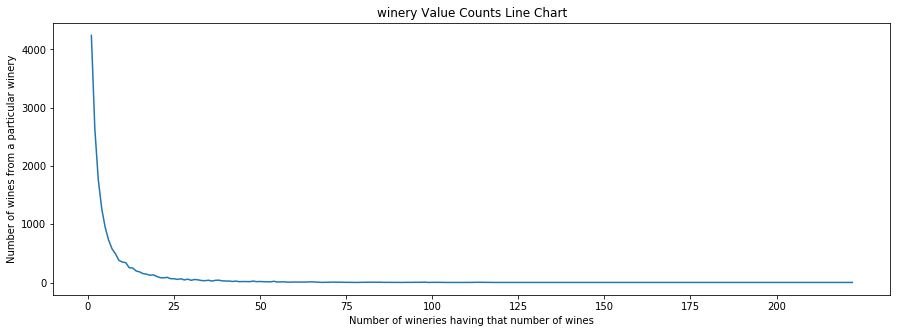

In [56]:
ax_13 = winery_value_counts.value_counts().sort_index().plot.line(title='winery Value Counts Line Chart', figsize=(15,5))

ax_13.set_xticks([0, 25, 50, 75, 100, 125, 150, 175, 200]);
ax_13.set_xticklabels([0, 25, 50, 75, 100, 125, 150, 175, 200]);
ax_13.set_xlabel('Number of wineries having that number of wines');
ax_13.set_ylabel('Number of wines from a particular winery');

### Decisions

Should some be left out?  
Should some be engineered?  
Did the engineering work? what did it do?  

At this point, I've decided that all of the non-text features aren't getting removed, which leaves title, description and designation. I've already decided that designation will be removed because it's just a list of unique descriptors for the wines, and so unless it I start analysing reoccuring words it offers no information from which to draw a pattern. Description could potentially be useful, but would require a significant diversion into NLP that is outside the scope of this project.  Title on the other hand - while superficially similar to description in usefulness - also contains a number representing a year: the vintage of the wine, which is what year the grapes were picked. If I can get that number out, then I get another numerical feature to use!

In [57]:
titles = feature_data.title.copy(deep=True)
# Checking winemag.com, their vintages only go back to 1900, so any number smaller than that isn't a date. 
years = titles.replace(r'.*((19|20)[0-9]{2}).*', r'\1', regex=True).replace(r'[A-Za-z]|[\D]|\s|(?:(?<!\d)\d{1}(?!\d))|(?:(?<!\d)\d{2}(?!\d))|(?:(?<!\d)\d{3}(?!\d))', '', regex=True)
print(years.sort_values().unique())
print(pd.to_numeric(years).describe())

['' '1503' '1607' '1821' '1827' '1847' '1868' '1872' '1882' '1887' '1903'
 '1904' '1905' '1906' '1907' '1908' '1909' '1910' '1912' '1913' '1914'
 '1916' '1918' '1919' '1922' '1924' '1927' '1930' '1934' '1935' '1939'
 '1940' '1941' '1945' '1947' '1951' '1952' '1953' '1955' '1957' '1961'
 '1963' '1964' '1965' '1966' '1967' '1968' '1969' '1970' '1973' '1974'
 '1975' '1976' '1978' '1979' '1980' '1982' '1983' '1984' '1985' '1986'
 '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995' '1996'
 '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005' '2006'
 '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016'
 '2017' '2067']
count    125362.000000
mean       2010.611948
std           4.868176
min        1503.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2067.000000
Name: title, dtype: float64


That looks usable! There are a bunch of years, some null values, and some obviously not year values because they describe future years or are numbers from before 1900. If I remove those, I get which year the grapes that the wine is made from were grown, and that should be useful. 

In [58]:
filtered_years = years.replace(r'(1503|1607|1821|1827|1847|1868|1872|1868|1872|1882|1887|2067)', '', regex=True)
print(filtered_years.sort_values().unique())
print(pd.to_numeric(filtered_years).describe())

['' '1903' '1904' '1905' '1906' '1907' '1908' '1909' '1910' '1912' '1913'
 '1914' '1916' '1918' '1919' '1922' '1924' '1927' '1930' '1934' '1935'
 '1939' '1940' '1941' '1945' '1947' '1951' '1952' '1953' '1955' '1957'
 '1961' '1963' '1964' '1965' '1966' '1967' '1968' '1969' '1970' '1973'
 '1974' '1975' '1976' '1978' '1979' '1980' '1982' '1983' '1984' '1985'
 '1986' '1987' '1988' '1989' '1990' '1991' '1992' '1993' '1994' '1995'
 '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004' '2005'
 '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015'
 '2016' '2017']
count    125344.000000
mean       2010.637534
std           4.158419
min        1903.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: title, dtype: float64


Accepting any further non-vintage numbers that happen to be in the range 1900-2018 as noise (I am not combing through 125344 records), I get 125344 records (>96% non-null data), which is just great (on the assumption that vintage actually matters....). 

In [59]:
# Rename filtered_years to vintage for ease of use
vintage = filtered_years
vintage_value_counts = vintage.value_counts()

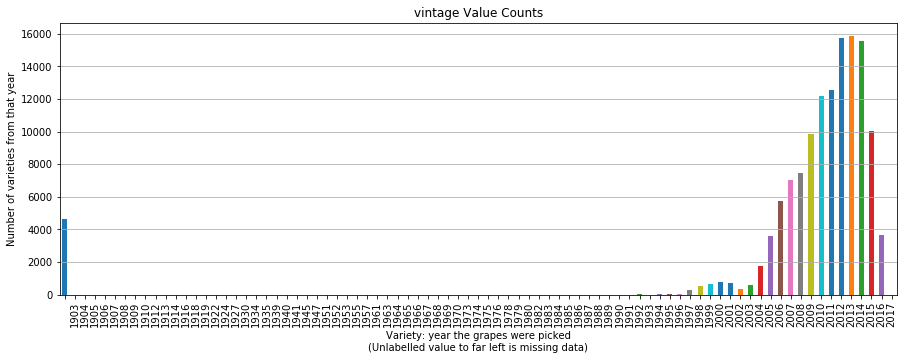

In [60]:
ax_14 = vintage_value_counts.sort_index().plot.bar(title='vintage Value Counts', figsize=(15,5))

ax_14.set_xlabel('Variety: year the grapes were picked\n(Unlabelled value to far left is missing data)');
ax_14.set_ylabel('Number of varieties from that year');
ax_14.grid(b=True, which='both', axis='y');

Clearly, most of the wine is more recently produced. Fortunately, the number of years with relatively _very_ low counts is not huge. Since this is a numeric variable, I will set the null values to zero. 

Thinking further about what data should be dropped, and what to do about the null data, I have decided to find out how many samples are left if I drop the rows with null data in the mostly-non-null columns, but ignore the columns with larger amounts of null values. 

In [61]:
raw_reduced_features = feature_data.drop(labels=['description', 'designation', 'title'], axis=1)
raw_reduced_features['vintage'] = vintage
raw_reduced_features

,country,price,province,region_1,region_2,taster_name,taster_twitter_handle,variety,winery,vintage
0,Italy,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,White Blend,Nicosia,2013
1,Portugal,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Portuguese Red,Quinta dos Avidagos,2011
2,US,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Pinot Gris,Rainstorm,2013
3,US,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,Riesling,St. Julian,2013
4,US,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Pinot Noir,Sweet Cheeks,2012
5,Spain,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tempranillo-Merlot,Tandem,2011
6,Italy,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Frappato,Terre di Giurfo,2013
7,France,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Gewürztraminer,Trimbach,2012
8,Germany,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Gewürztraminer,Heinz Eifel,2013
9,France,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Pinot Gris,Jean-Baptiste Adam,2012


In [62]:
df_non_null_reduced_features = raw_reduced_features.dropna(subset=['country', 'province','region_1','taster_name','variety','winery', 'vintage'], axis='index', how='any')
print('Number of rows with no null values: {}'.format(df_non_null_reduced_features.shape[0]))

Number of rows with no null values: 82847


That's still a lot of rows, although it's only ~64% of the dataset. I am sure that a version with all the features included in binarised or encoded forms will result in more accurate models, but for the purposes of completeness I will use this entirely non-null, smaller dataset to see what the actual difference is. As they say: _trust, but verify_. 

#### Encoding
As for representing the categorical variables, I've decided to create two different representations of the same data - one with one hot encoding and one with ordinal numerical encoding. My reason for this is that ordinal numerical encoding keeps dimensionality down but implicitly introduces ordinality to non-ordinal data, while one hot encoding doesn't introduce any new relationship between the data, but does create a large number of new dimensions and can make parts of datasets sparse, and I don't know which is better in this case. I will try both and learn what works best in this case. 

Unfortunately, after doing some maths, I've realised that one hot encoding would add approximately 19213 dimensions to the dataset, and make it incredibly sparse. I'm going to attempt it, but the machine I'm using for this can't handle processing datasets so large, so it probably won't work. As a compromise, I'll create another version of the dataset where I'll use one hot encoding for some of the categorical features with fewer unique values, such as taster_name and country. 

#### Null values
The first thing I'm going to do with null values is leave them all as zero. If results are poor, then I'll consider some form of imputation, but since doing so always has tradeoffs and the lack of data could be relevant in of itself, I'll do nothing for it in this case unless I really need to. 

In [63]:
categorical_features_for_encoding = ['country', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'variety', 'winery']

### Features

In [64]:
country = raw_reduced_features.country
price = raw_reduced_features.price
province = raw_reduced_features.province
region_1 = raw_reduced_features.region_1
region_2 = raw_reduced_features.region_2
taster_name = raw_reduced_features.taster_name
taster_twitter_handle = raw_reduced_features.taster_twitter_handle
variety = raw_reduced_features.variety
winery = raw_reduced_features.winery
vintage = raw_reduced_features.vintage

### Ordinal numerical encoding

In [65]:
# country
label_encoder_country = LabelEncoder()
label_encoder_country.fit(country.astype(str))

encoded_countries = label_encoder_country.transform(country.astype(str))

print(country[:10])
print(label_encoder_country.inverse_transform(encoded_countries[:10]))

0       Italy
1    Portugal
2          US
3          US
4          US
5       Spain
6       Italy
7      France
8     Germany
9      France
Name: country, dtype: object
['Italy' 'Portugal' 'US' 'US' 'US' 'Spain' 'Italy' 'France' 'Germany'
 'France']


In [66]:
# province
label_encoder_province = LabelEncoder()
label_encoder_province.fit(province.astype(str))

encoded_provinces = label_encoder_province.transform(province.astype(str))

print(province[:10])
print(label_encoder_province.inverse_transform(encoded_provinces[:10]))

0    Sicily & Sardinia
1                Douro
2               Oregon
3             Michigan
4               Oregon
5       Northern Spain
6    Sicily & Sardinia
7               Alsace
8          Rheinhessen
9               Alsace
Name: province, dtype: object
['Sicily & Sardinia' 'Douro' 'Oregon' 'Michigan' 'Oregon' 'Northern Spain'
 'Sicily & Sardinia' 'Alsace' 'Rheinhessen' 'Alsace']


In [67]:
# region_1
label_encoder_region_1 = LabelEncoder()
label_encoder_region_1.fit(region_1.astype(str))

encoded_region_1s = label_encoder_region_1.transform(region_1.astype(str))

print(region_1[:10])
print(label_encoder_region_1.inverse_transform(encoded_region_1s[:10]))

0                   Etna
1                    NaN
2      Willamette Valley
3    Lake Michigan Shore
4      Willamette Valley
5                Navarra
6               Vittoria
7                 Alsace
8                    NaN
9                 Alsace
Name: region_1, dtype: object
['Etna' 'nan' 'Willamette Valley' 'Lake Michigan Shore'
 'Willamette Valley' 'Navarra' 'Vittoria' 'Alsace' 'nan' 'Alsace']


In [68]:
# region_2
label_encoder_region_2 = LabelEncoder()
label_encoder_region_2.fit(region_2.astype(str))

encoded_region_2s = label_encoder_region_2.transform(region_2.astype(str))

print(region_2[:10])
print(label_encoder_region_2.inverse_transform(encoded_region_2s[:10]))

0                  NaN
1                  NaN
2    Willamette Valley
3                  NaN
4    Willamette Valley
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
Name: region_2, dtype: object
['nan' 'nan' 'Willamette Valley' 'nan' 'Willamette Valley' 'nan' 'nan'
 'nan' 'nan' 'nan']


In [69]:
# taster_name
label_encoder_taster_name = LabelEncoder()
label_encoder_taster_name.fit(taster_name.astype(str))

encoded_taster_names = label_encoder_taster_name.transform(taster_name.astype(str))

print(taster_name[:10])
print(label_encoder_taster_name.inverse_transform(encoded_taster_names[:10]))

0         Kerin O’Keefe
1            Roger Voss
2          Paul Gregutt
3    Alexander Peartree
4          Paul Gregutt
5     Michael Schachner
6         Kerin O’Keefe
7            Roger Voss
8    Anna Lee C. Iijima
9            Roger Voss
Name: taster_name, dtype: object
['Kerin O’Keefe' 'Roger Voss' 'Paul Gregutt' 'Alexander Peartree'
 'Paul Gregutt' 'Michael Schachner' 'Kerin O’Keefe' 'Roger Voss'
 'Anna Lee C. Iijima' 'Roger Voss']


In [70]:
# taster_twitter_handle
label_encoder_taster_twitter_handle = LabelEncoder()
label_encoder_taster_twitter_handle.fit(taster_twitter_handle.astype(str))

encoded_taster_twitter_handles = label_encoder_taster_twitter_handle.transform(taster_twitter_handle.astype(str))

print(taster_twitter_handle[:10])
print(label_encoder_taster_twitter_handle.inverse_transform(encoded_taster_twitter_handles[:10]))

0    @kerinokeefe
1      @vossroger
2     @paulgwine 
3             NaN
4     @paulgwine 
5     @wineschach
6    @kerinokeefe
7      @vossroger
8             NaN
9      @vossroger
Name: taster_twitter_handle, dtype: object
['@kerinokeefe' '@vossroger' '@paulgwine\xa0' 'nan' '@paulgwine\xa0'
 '@wineschach' '@kerinokeefe' '@vossroger' 'nan' '@vossroger']


In [71]:
# variety
label_encoder_variety = LabelEncoder()
label_encoder_variety.fit(variety.astype(str))

encoded_varieties = label_encoder_variety.transform(variety.astype(str))

print(variety[:10])
print(label_encoder_variety.inverse_transform(encoded_varieties[:10]))

0           White Blend
1        Portuguese Red
2            Pinot Gris
3              Riesling
4            Pinot Noir
5    Tempranillo-Merlot
6              Frappato
7        Gewürztraminer
8        Gewürztraminer
9            Pinot Gris
Name: variety, dtype: object
['White Blend' 'Portuguese Red' 'Pinot Gris' 'Riesling' 'Pinot Noir'
 'Tempranillo-Merlot' 'Frappato' 'Gewürztraminer' 'Gewürztraminer'
 'Pinot Gris']


In [72]:
# winery
label_encoder_winery = LabelEncoder()
label_encoder_winery.fit(winery.astype(str))

encoded_wineries = label_encoder_winery.transform(winery.astype(str))

print(winery[:10])
print(label_encoder_winery.inverse_transform(encoded_wineries[:10]))

0                Nicosia
1    Quinta dos Avidagos
2              Rainstorm
3             St. Julian
4           Sweet Cheeks
5                 Tandem
6        Terre di Giurfo
7               Trimbach
8            Heinz Eifel
9     Jean-Baptiste Adam
Name: winery, dtype: object
['Nicosia' 'Quinta dos Avidagos' 'Rainstorm' 'St. Julian' 'Sweet Cheeks'
 'Tandem' 'Terre di Giurfo' 'Trimbach' 'Heinz Eifel' 'Jean-Baptiste Adam']


In [73]:
# Label encoded feature DataFrame
feature_data_label_encoded = feature_data.copy(deep=False)
feature_data_label_encoded = feature_data_label_encoded.drop(labels=['description', 'designation', 'title'], axis=1)
feature_data_label_encoded['vintage'] = vintage

feature_data_label_encoded.country = encoded_countries
feature_data_label_encoded.province = encoded_provinces
feature_data_label_encoded.region_1 = encoded_region_1s
feature_data_label_encoded.region_2 = encoded_region_2s
feature_data_label_encoded.taster_name = encoded_taster_names
feature_data_label_encoded.taster_twitter_handle = encoded_taster_twitter_handles
feature_data_label_encoded.variety = encoded_varieties
feature_data_label_encoded.winery = encoded_wineries

print(feature_data_label_encoded.shape)
feature_data_label_encoded.sample(5, random_state=4)

(129971, 10)


,country,price,province,region_1,region_2,taster_name,taster_twitter_handle,variety,winery,vintage
105424,15,35.0,11,21,17,15,10,440,9104,2010
30811,40,46.0,51,972,1,11,6,125,13797,2013
86983,22,20.0,331,424,17,9,4,690,244,2015
109619,40,14.0,51,185,1,19,15,125,5345,2008
98442,15,NaN,36,817,17,15,10,62,4071,2009


Looks like it works. For the training, I will also standardise of price and vintage. 

### One hot encoding

In [74]:
# country
one_hot_country = OneHotEncoder(sparse=False)
one_hot_country.fit(country.astype(str).values.reshape(-1,1))

one_hot_countries = one_hot_country.transform(country.astype(str).values.reshape(-1,1))

print(country[:10])
print(one_hot_country.inverse_transform(one_hot_countries[:10]))

0       Italy
1    Portugal
2          US
3          US
4          US
5       Spain
6       Italy
7      France
8     Germany
9      France
Name: country, dtype: object
[['Italy']
 ['Portugal']
 ['US']
 ['US']
 ['US']
 ['Spain']
 ['Italy']
 ['France']
 ['Germany']
 ['France']]


In [75]:
# country
one_hot_country = OneHotEncoder(sparse=False)
one_hot_country.fit(country.astype(str).values.reshape(-1,1))

one_hot_countries = one_hot_country.transform(country.astype(str).values.reshape(-1,1))

print(country[:10])
print(one_hot_country.inverse_transform(one_hot_countries[:10]))

0       Italy
1    Portugal
2          US
3          US
4          US
5       Spain
6       Italy
7      France
8     Germany
9      France
Name: country, dtype: object
[['Italy']
 ['Portugal']
 ['US']
 ['US']
 ['US']
 ['Spain']
 ['Italy']
 ['France']
 ['Germany']
 ['France']]


In [76]:
# province
one_hot_province = OneHotEncoder(sparse=False)
one_hot_province.fit(province.astype(str).values.reshape(-1,1))

one_hot_provinces = one_hot_province.transform(province.astype(str).values.reshape(-1,1))

print(province[:10])
print(one_hot_province.inverse_transform(one_hot_provinces[:10]))

0    Sicily & Sardinia
1                Douro
2               Oregon
3             Michigan
4               Oregon
5       Northern Spain
6    Sicily & Sardinia
7               Alsace
8          Rheinhessen
9               Alsace
Name: province, dtype: object
[['Sicily & Sardinia']
 ['Douro']
 ['Oregon']
 ['Michigan']
 ['Oregon']
 ['Northern Spain']
 ['Sicily & Sardinia']
 ['Alsace']
 ['Rheinhessen']
 ['Alsace']]


In [77]:
# region_1
one_hot_region_1 = OneHotEncoder(sparse=False)
one_hot_region_1.fit(region_1.astype(str).values.reshape(-1,1))

one_hot_region_1s = one_hot_region_1.transform(region_1.astype(str).values.reshape(-1,1))

print(region_1[:10])
print(one_hot_region_1.inverse_transform(one_hot_region_1s[:10]))

0                   Etna
1                    NaN
2      Willamette Valley
3    Lake Michigan Shore
4      Willamette Valley
5                Navarra
6               Vittoria
7                 Alsace
8                    NaN
9                 Alsace
Name: region_1, dtype: object
[['Etna']
 ['nan']
 ['Willamette Valley']
 ['Lake Michigan Shore']
 ['Willamette Valley']
 ['Navarra']
 ['Vittoria']
 ['Alsace']
 ['nan']
 ['Alsace']]


In [78]:
# region_2
one_hot_region_2 = OneHotEncoder(sparse=False)
one_hot_region_2.fit(region_2.astype(str).values.reshape(-1,1))

one_hot_region_2s = one_hot_region_2.transform(region_2.astype(str).values.reshape(-1,1))

print(region_2[:10])
print(one_hot_region_2.inverse_transform(one_hot_region_2s[:10]))

0                  NaN
1                  NaN
2    Willamette Valley
3                  NaN
4    Willamette Valley
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
Name: region_2, dtype: object
[['nan']
 ['nan']
 ['Willamette Valley']
 ['nan']
 ['Willamette Valley']
 ['nan']
 ['nan']
 ['nan']
 ['nan']
 ['nan']]


In [79]:
# taster_name
one_hot_taster_name = OneHotEncoder(sparse=False)
one_hot_taster_name.fit(taster_name.astype(str).values.reshape(-1,1))

one_hot_taster_names = one_hot_taster_name.transform(taster_name.astype(str).values.reshape(-1,1))

print(taster_name[:10])
print(one_hot_taster_name.inverse_transform(one_hot_taster_names[:10]))

0         Kerin O’Keefe
1            Roger Voss
2          Paul Gregutt
3    Alexander Peartree
4          Paul Gregutt
5     Michael Schachner
6         Kerin O’Keefe
7            Roger Voss
8    Anna Lee C. Iijima
9            Roger Voss
Name: taster_name, dtype: object
[['Kerin O’Keefe']
 ['Roger Voss']
 ['Paul Gregutt']
 ['Alexander Peartree']
 ['Paul Gregutt']
 ['Michael Schachner']
 ['Kerin O’Keefe']
 ['Roger Voss']
 ['Anna Lee C. Iijima']
 ['Roger Voss']]


In [80]:
# taster_twitter_handle
one_hot_taster_twitter_handle = OneHotEncoder(sparse=False)
one_hot_taster_twitter_handle.fit(taster_twitter_handle.astype(str).values.reshape(-1,1))

one_hot_taster_twitter_handles = one_hot_taster_twitter_handle.transform(taster_twitter_handle.astype(str).values.reshape(-1,1))

print(taster_twitter_handle[:10])
print(one_hot_taster_twitter_handle.inverse_transform(one_hot_taster_twitter_handles[:10]))

0    @kerinokeefe
1      @vossroger
2     @paulgwine 
3             NaN
4     @paulgwine 
5     @wineschach
6    @kerinokeefe
7      @vossroger
8             NaN
9      @vossroger
Name: taster_twitter_handle, dtype: object
[['@kerinokeefe']
 ['@vossroger']
 ['@paulgwine\xa0']
 ['nan']
 ['@paulgwine\xa0']
 ['@wineschach']
 ['@kerinokeefe']
 ['@vossroger']
 ['nan']
 ['@vossroger']]


In [81]:
# variety
one_hot_variety = OneHotEncoder(sparse=False)
one_hot_variety.fit(variety.astype(str).values.reshape(-1,1))

one_hot_varieties = one_hot_variety.transform(variety.astype(str).values.reshape(-1,1))

print(variety[:10])
print(one_hot_variety.inverse_transform(one_hot_varieties[:10]))

0           White Blend
1        Portuguese Red
2            Pinot Gris
3              Riesling
4            Pinot Noir
5    Tempranillo-Merlot
6              Frappato
7        Gewürztraminer
8        Gewürztraminer
9            Pinot Gris
Name: variety, dtype: object
[['White Blend']
 ['Portuguese Red']
 ['Pinot Gris']
 ['Riesling']
 ['Pinot Noir']
 ['Tempranillo-Merlot']
 ['Frappato']
 ['Gewürztraminer']
 ['Gewürztraminer']
 ['Pinot Gris']]


In [82]:
# winery
one_hot_winery = OneHotEncoder(sparse=False)
one_hot_winery.fit(winery.astype(str).values.reshape(1,-1))

one_hot_wineries = one_hot_winery.transform(winery.astype(str).values.reshape(1,-1))

print(winery[:10])
print(one_hot_winery.inverse_transform(one_hot_wineries[:10]))
# I have had to do this reshape the wrong way round, then redo it here to avoid 'MemoryError:'s with no further info. 

# one_hot_wineries = one_hot_wineries.reshape(-1,1)

0                Nicosia
1    Quinta dos Avidagos
2              Rainstorm
3             St. Julian
4           Sweet Cheeks
5                 Tandem
6        Terre di Giurfo
7               Trimbach
8            Heinz Eifel
9     Jean-Baptiste Adam
Name: winery, dtype: object
[['Nicosia' 'Quinta dos Avidagos' 'Rainstorm' ... 'Domaine Gresser'
  'Domaine Marcel Deiss' 'Domaine Schoffit']]


In [83]:
# # One hot encoded feature DataFrame
# feature_data_one_hot_encoded = feature_data.copy(deep=False)
# feature_data_one_hot_encoded = feature_data_one_hot_encoded.drop(labels=['description', 'designation', 'title', 'country', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'variety', 'winery'], axis=1)
# feature_data_one_hot_encoded['vintage'] = vintage

# one_hot_countries_df = pd.DataFrame(data=one_hot_countries, columns=one_hot_country.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_countries_df], axis=1)

# one_hot_provinces_df = pd.DataFrame(data=one_hot_provinces, columns=one_hot_province.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_provinces_df], axis=1)

# one_hot_region_1s_df = pd.DataFrame(data=one_hot_region_1s, columns=one_hot_region_1.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_region_1s_df], axis=1)

# one_hot_region_2s_df = pd.DataFrame(data=one_hot_region_2s, columns=one_hot_region_2.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_region_2s_df], axis=1)

# one_hot_taster_names_df = pd.DataFrame(data=one_hot_taster_names, columns=one_hot_taster_name.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_taster_names_df], axis=1)

# one_hot_taster_twitter_handles_df = pd.DataFrame(data=one_hot_taster_twitter_handles, columns=one_hot_taster_twitter_handle.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_taster_twitter_handles_df], axis=1)

# one_hot_varieties_df = pd.DataFrame(data=one_hot_varieties, columns=one_hot_variety.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_varieties_df], axis=1)

# one_hot_wineries_df = pd.DataFrame(data=one_hot_wineries.reshape(-1,1), columns=one_hot_winery.categories_[0])
# feature_data_one_hot_encoded = pd.concat([feature_data_one_hot_encoded, one_hot_wineries_df], axis=1)

# print(feature_data_one_hot_encoded.shape)
# feature_data_one_hot_encoded.sample(5, random_state=4)

So it turns out that I get `MemoryError:` (with no further detail) before I even get past region_2. Apparently I'll need a bigger computer for that sort of thing. In the meantime, I'll try a partially one hot encoded version. 

### Mixed encoding

Copying a table I made earlier:

|Feature|Non-null|Null|Percentage null|Count of unique values|
|---|---|---|---|---|
|country|129,908|63|0.05%|43|
|province|129,908|63|0.05%|425|
|region_1|108,724|21,247|16.35%|1229|
|region_2|50,511|79,460|61.14%|17|
|taster_name|103,727|26,244|20.19%|19|
|taster_twitter_handle|98,758|31,213|24.02%|15|
|variety|129,970|1|0.00%|707|
|winery|129,971|0|0.00%|16757|

I'm thinking that anything with fewer than 100 unique values can be encoded without inflicting the curse of dimensionality (or worse, the dreaded `MemoryError:`). That means: 
1. country
2. region_2
3. taster_name
4. taster_twitter_handle

Fortunately, I've already written code to do all that. 

In [84]:
# Mixed encoding feature DataFrame
feature_data_mixed_encoding = feature_data.copy(deep=False)
feature_data_mixed_encoding = feature_data_mixed_encoding.drop(labels=['description', 'designation', 'title'], axis=1)
feature_data_mixed_encoding['vintage'] = vintage

# Label encoding
feature_data_mixed_encoding.province = encoded_provinces
feature_data_mixed_encoding.region_1 = encoded_region_1s
feature_data_mixed_encoding.variety = encoded_varieties
feature_data_mixed_encoding.winery = encoded_wineries

# One hot encoding
feature_data_mixed_encoding = feature_data_mixed_encoding.drop(labels=['country', 'region_2', 'taster_name', 'taster_twitter_handle'], axis=1)

one_hot_countries_df = pd.DataFrame(data=one_hot_countries, columns=one_hot_country.categories_[0])
feature_data_mixed_encoding = pd.concat([feature_data_mixed_encoding, one_hot_countries_df], axis=1)
one_hot_countries_df = one_hot_countries_df.rename(columns={"nan":"country_nan"})

one_hot_region_2s_df = pd.DataFrame(data=one_hot_region_2s, columns=one_hot_region_2.categories_[0])
feature_data_mixed_encoding = pd.concat([feature_data_mixed_encoding, one_hot_region_2s_df], axis=1)
one_hot_region_2s_df = one_hot_region_2s_df.rename(columns={"nan":"region_2_nan"})

one_hot_taster_names_df = pd.DataFrame(data=one_hot_taster_names, columns=one_hot_taster_name.categories_[0])
feature_data_mixed_encoding = pd.concat([feature_data_mixed_encoding, one_hot_taster_names_df], axis=1)
one_hot_taster_names_df = one_hot_taster_names_df.rename(columns={"nan":"taster_name_nan"})

one_hot_taster_twitter_handles_df = pd.DataFrame(data=one_hot_taster_twitter_handles, columns=one_hot_taster_twitter_handle.categories_[0])
feature_data_mixed_encoding = pd.concat([feature_data_mixed_encoding, one_hot_taster_twitter_handles_df], axis=1)
one_hot_taster_twitter_handles_df = one_hot_taster_twitter_handles_df.rename(columns={"nan":"taster_twitter_handle_nan"})

print(feature_data_mixed_encoding.shape)
feature_data_mixed_encoding.sample(10, random_state=4)

(129971, 104)


,price,province,region_1,variety,winery,vintage,Argentina,Armenia,Australia,Austria,...,@mattkettmann,@paulgwine,@suskostrzewa,@vboone,@vossroger,@wawinereport,@wineschach,@winewchristina,@worldwineguys,nan
105424,35.0,11,21,440,9104,2010,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
30811,46.0,51,972,125,13797,2013,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86983,20.0,331,424,690,244,2015,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109619,14.0,51,185,125,5345,2008,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98442,NaN,36,817,62,4071,2009,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
122061,38.0,51,964,473,11479,2012,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88897,NaN,353,1229,690,10524,2009,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
102633,38.0,216,633,80,14603,2012,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
84660,11.0,299,366,492,6154,2009,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
60227,90.0,374,1078,473,2503,2009,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


That looks good. I that there were four one hot encoded columns named 'nan', one from each feature encoded that way, and renamed them. 

In terms of what else there is to be done that is useful - I think that's it. I've examined the features, discarded any that were too difficult to use, engineered a new one out of an otherwise unusable one, and tested how the categorical text data can be transformed to be usable for training. 

Remembering that the reason I am working on this dataset is to find out how to pick good wine in a shop, I'll take what I've got here and start a new notebook to being the data analysis and model building in order to solve that problem. 